# Import Libraries

In [1]:
import os
import random
from PIL import Image
import cv2
import tifffile as tiff
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Input, Dropout, UpSampling2D, concatenate, Conv2DTranspose
from keras.regularizers import l2
from keras.optimizers import Adamax, Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, BinaryIoU
from keras.callbacks import EarlyStopping
from keras.models import load_model

2025-07-18 12:59:28.387750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752843568.776248      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752843568.880336      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Read and Prepare Data

In [2]:
dataset_path = '/kaggle/input/satalite-data/data'
dataset_dir = os.listdir(dataset_path)
print(f'The Dataset directory constists of {dataset_dir} directories.')

The Dataset directory constists of ['labels', 'images'] directories.


In [3]:
image_dir = dataset_path + '/images'
image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
images = [tiff.imread(image_path) for image_path in image_paths]

In [4]:
mask_dir = dataset_path + '/labels'

# Exclude file containing '_' in their name
mask_paths = [c for c in sorted(glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(c)]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# Data Preprocessing

> Apply Normalization

In [5]:
# Preprocess per image
def preprocess(dataset):
    return [(image - np.min(image)) / (np.max(image) - np.min(image) + 1e-5) for image in dataset]

# Preprocess per band
def preprocess_per_band(dataset):
    norm_dataset = []
    for image in dataset:
        norm_image = np.zeros_like(image, dtype=np.float32)
        for b in range(image.shape[-1]):
            band = image[:, :, b]
            band_min = np.min(band)
            band_max = np.max(band)
            norm_image[:, :, b] = (band - band_min) / (band_max - band_min + 1e-5)
        norm_dataset.append(norm_image)
    return norm_dataset

# Preprocess globally
def preprocess_global(dataset):
    num_bands = dataset[0].shape[-1]
    global_mins = np.full(num_bands, np.inf)
    global_maxs = np.full(num_bands, -np.inf)
    
    for img in dataset:
        for b in range(num_bands):
            global_mins[b] = min(global_mins[b], np.min(img[:, :, b]))
            global_maxs[b] = max(global_maxs[b], np.max(img[:, :, b]))

    band_stats = pd.DataFrame({
        'Band': [f'Band {i+1}' for i in range(num_bands)],
        'Min': global_mins,
        'Max': global_maxs
    })
    
    norm_dataset = []
    for img in dataset:
        norm_img = np.zeros_like(img, dtype=np.float32)
        for b in range(num_bands):
            norm_img[:, :, b] = (img[:, :, b] - global_mins[b]) / (global_maxs[b] - global_mins[b] + 1e-5)
        norm_dataset.append(norm_img)
    return band_stats, norm_dataset

In [6]:
bands, images = preprocess_global(images)
print('Original min and max for bands before applying normalization')
bands

Original min and max for bands before applying normalization


,Band,Min,Max
0,Band 1,-1393.0,6568.0
1,Band 2,-1169.0,9659.0
2,Band 3,-722.0,11368.0
3,Band 4,-684.0,12041.0
4,Band 5,-412.0,15841.0
5,Band 6,-335.0,15252.0
6,Band 7,-258.0,14647.0
7,Band 8,64.0,255.0
8,Band 9,-9999.0,4245.0
9,Band 10,8.0,4287.0


# Data Visualization

## Band Visualization functions

In [7]:
def plot_band_histograms(images, bins=50):
    fig, axes = plt.subplots(3, 4, figsize=(20, 10))
    axes = axes.flatten()
    fig.suptitle('Histogram of Pixel Distribution', fontsize=15)

    for b in range(12):
        band_pixels = []
        for img in images:
            band_pixels.extend(img[:, :, b].flatten())
        
        axes[b].hist(band_pixels, bins=bins, edgecolor='black')
        axes[b].set_title(f'Band {b+1}')
        axes[b].set_xlabel('Pixel Value')
        axes[b].set_ylabel('Frequency')
        axes[b].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


In [8]:
def visualize_image_bands(image, title='Image Bands'):
    num_bands = image.shape[-1]
    bands = ['Coastal aerosal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA Band'
             , 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurence probability']
    fig, axes = plt.subplots(1, num_bands, figsize=(25, 3))
    fig.suptitle(title, fontsize=15)

    for i in range(num_bands):
        ax = axes[i] if num_bands > 1 else axes
        ax.imshow(image[:, :, i], cmap='gray')
        ax.set_title(f'Band {i + 1}\n{bands[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## visualize histograms of pixel distributions per band

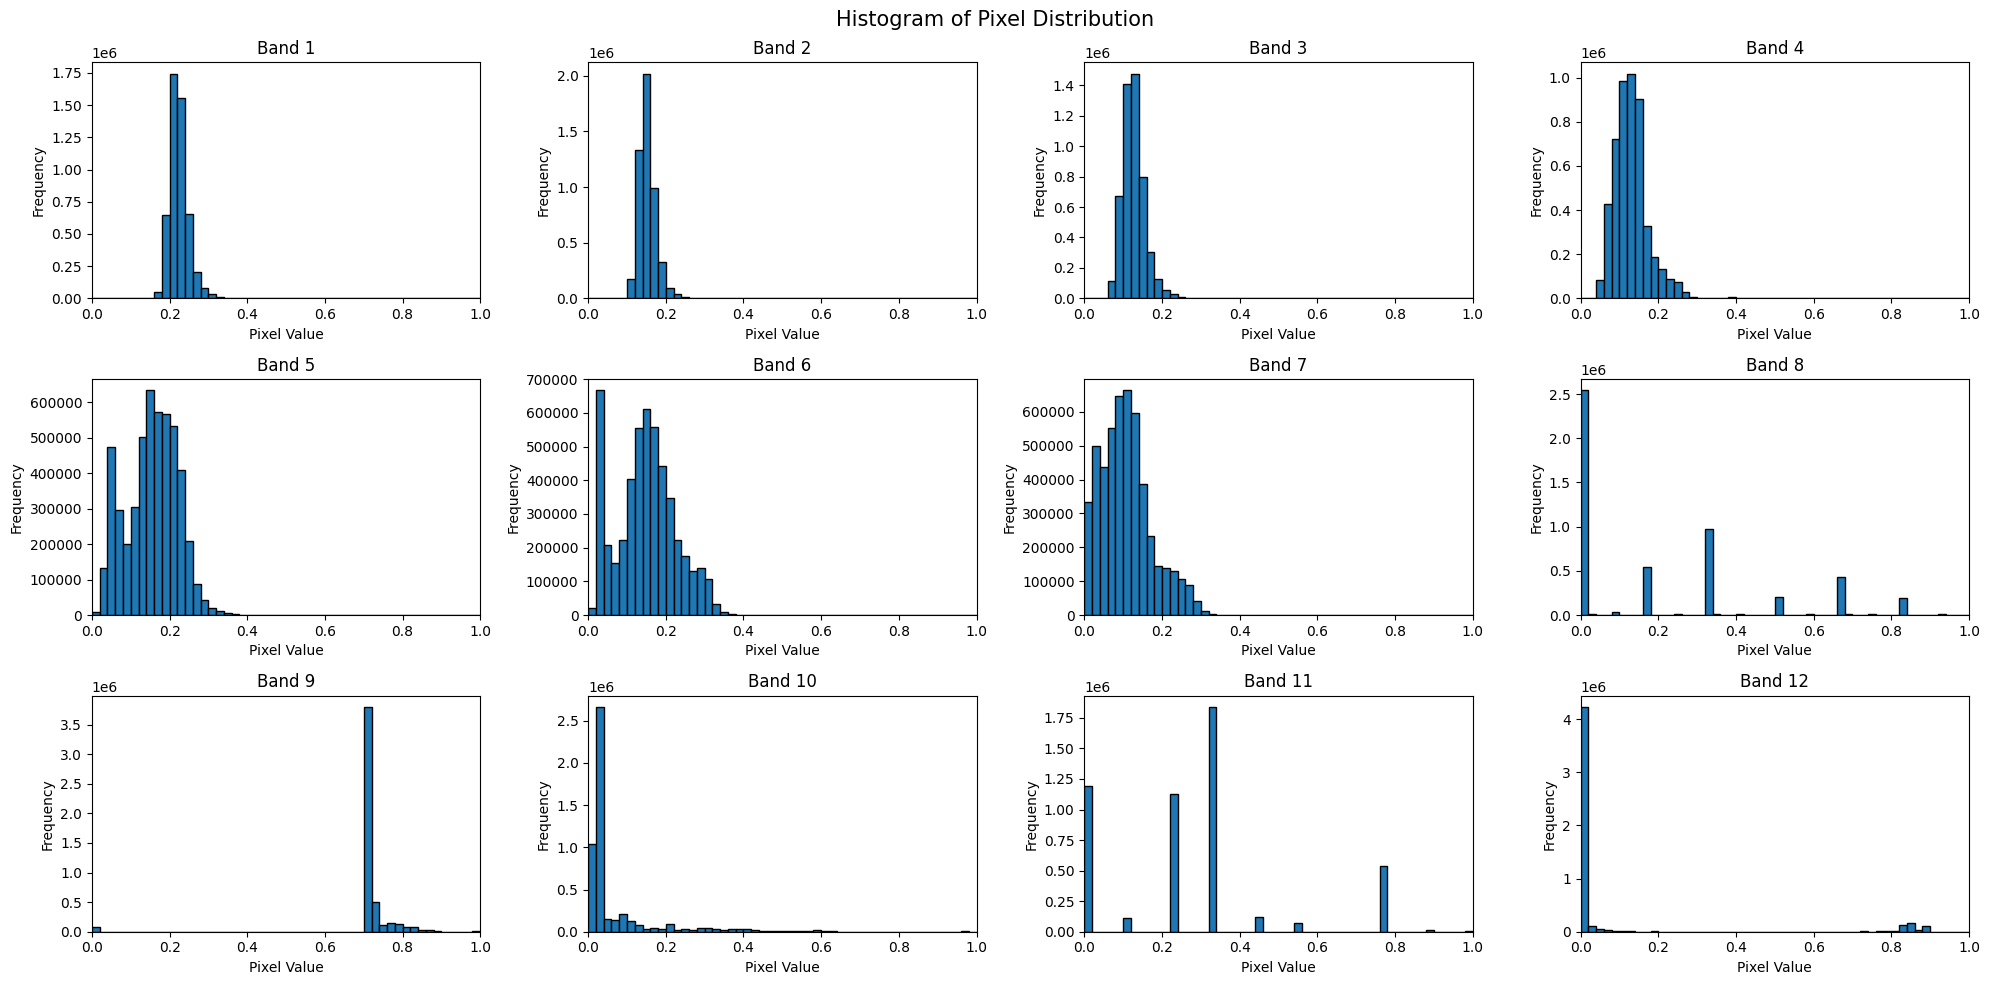

In [9]:
plot_band_histograms(images)


## visualize the bands of first 5 images

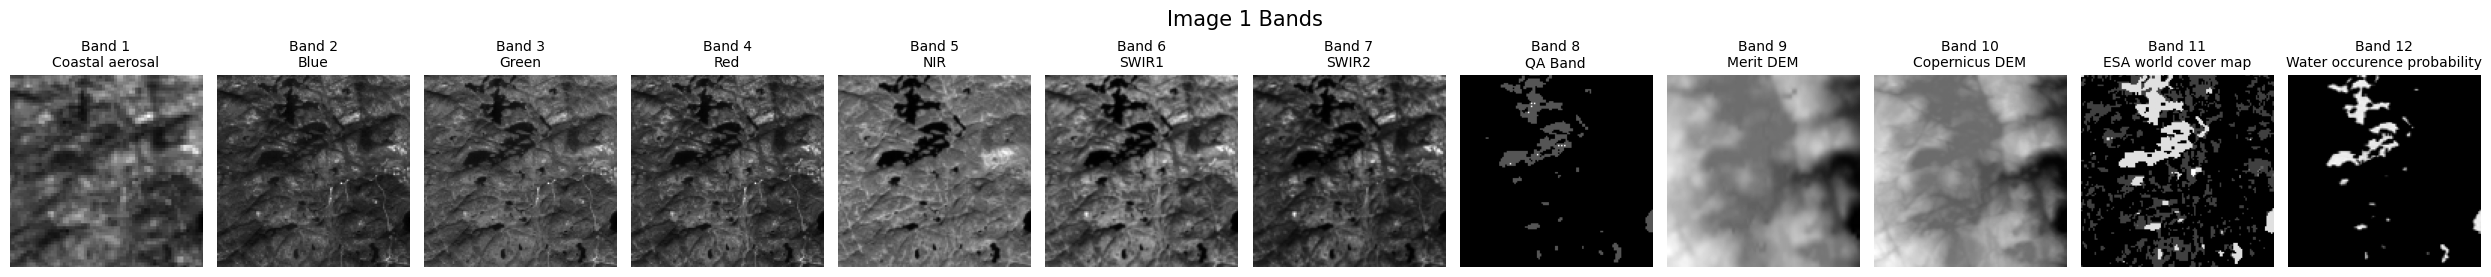

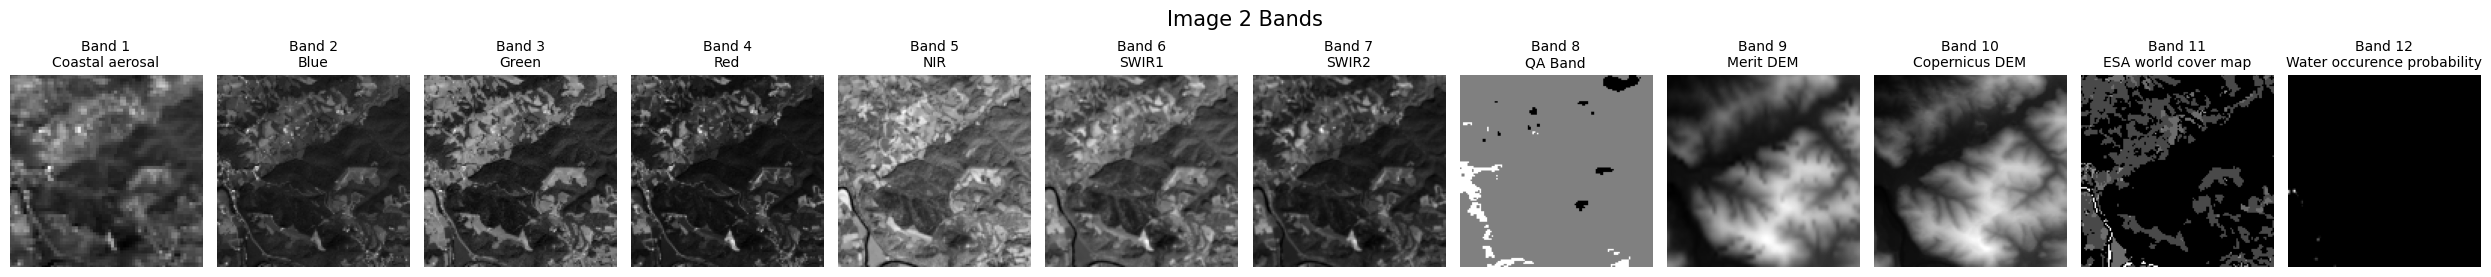

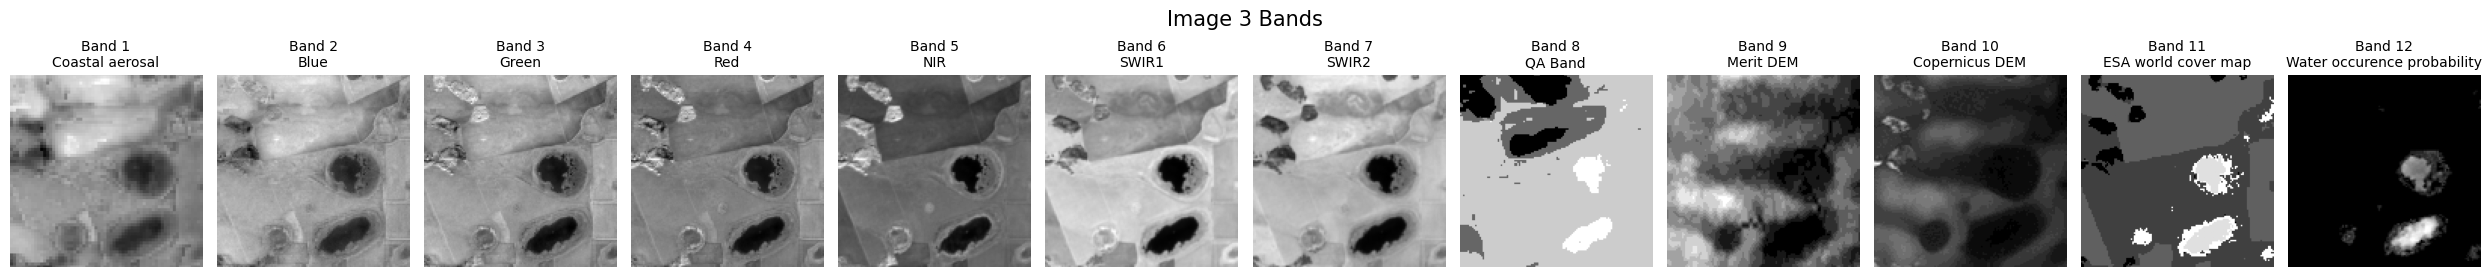

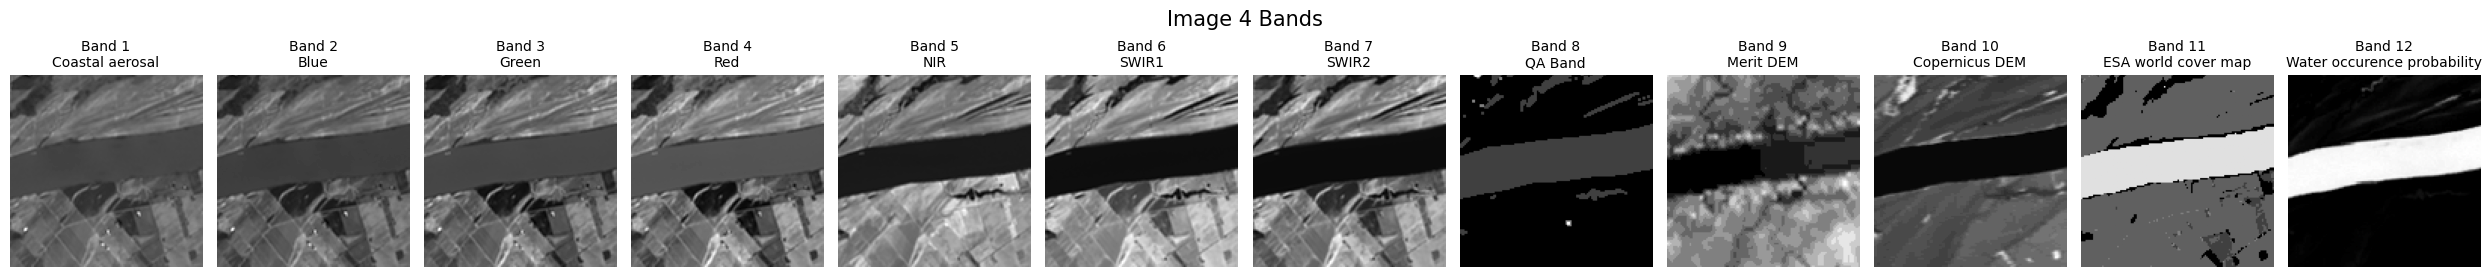

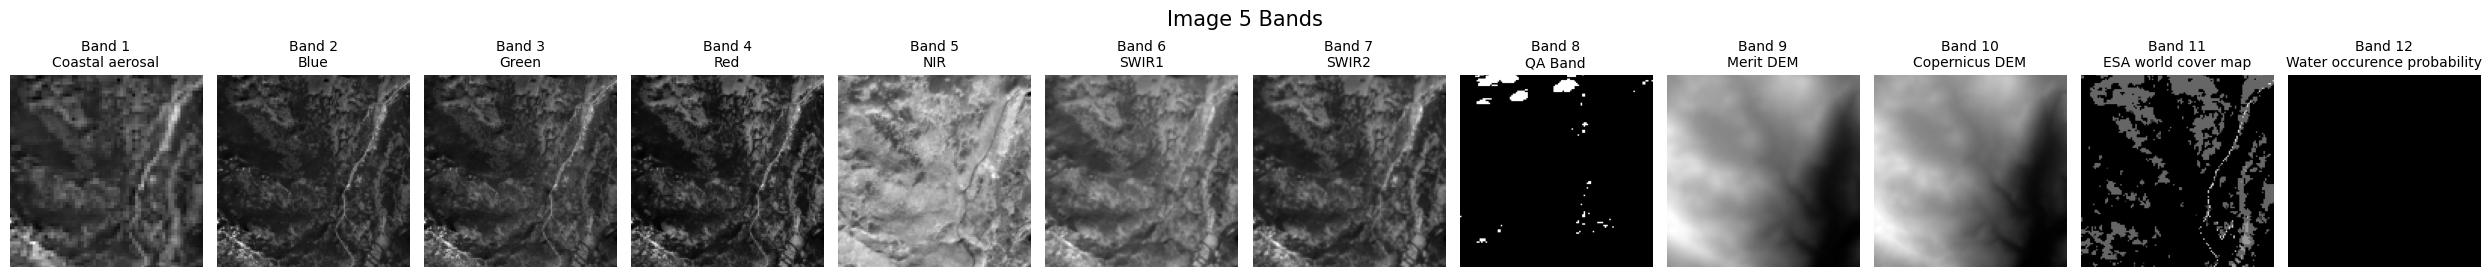

In [10]:
for i in range(5):
    visualize_image_bands(images[i], f'Image {i + 1} Bands')

> split data into 80% for training and 20% for testing

In [11]:
train_size = int(0.8 * len(images))

x_train, x_test = images[:train_size], images[train_size:]
y_train, y_test = masks[:train_size], masks[train_size:]

In [12]:
print (f'x_train shape: {np.array(x_train).shape}\nx_test shape: {np.array(x_test).shape}')

x_train shape: (244, 128, 128, 12)
x_test shape: (62, 128, 128, 12)


# Model Architecture

> UNet Model 

In [13]:
def UNet_from_Scratch():
    # Input Layer
    inputs = Input((128, 128, 12))

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy',
                          BinaryIoU(target_class_ids=[1], threshold=0.5, name='iou'),
                          Precision(name='precision'),
                          Recall(name='recall')])
    return model

In [24]:
model = UNet_from_Scratch()

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(
    np.array(x_train), np.array(y_train),
    validation_data=(np.array(x_test), np.array(y_test)),
    epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5906 - iou: 0.1871 - loss: 0.8000 - precision: 0.3197 - recall: 0.3819 - val_accuracy: 0.8242 - val_iou: 0.2570 - val_loss: 0.6306 - val_precision: 0.9974 - val_recall: 0.2571
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step - accuracy: 0.8215 - iou: 0.3776 - loss: 0.5914 - precision: 0.8941 - recall: 0.4033 - val_accuracy: 0.8564 - val_iou: 0.3957 - val_loss: 0.4945 - val_precision: 0.9881 - val_recall: 0.3976
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - accuracy: 0.8536 - iou: 0.4295 - loss: 0.4558 - precision: 0.9486 - recall: 0.4425 - val_accuracy: 0.8921 - val_iou: 0.5635 - val_loss: 0.3805 - val_precision: 0.9280 - val_recall: 0.5893
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 526ms/step - accuracy: 0.8811 - iou: 0.5655 - loss: 0.3709 - precision: 0.9292 - recall: 0.5912 - val_accuracy: 0.8973 - val_iou: 0.5888 - val_loss: 0.3225 - val_precision: 0.9175 - val_recall: 0.6217
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4

# Model Evaluation

In [16]:
def model_evaluation(model):
    train_loss, train_acc, train_iou, train_prec, train_rec = model.evaluate(np.array(x_train), np.array(y_train))
    test_loss, test_acc, test_iou, test_prec, test_rec = model.evaluate(np.array(x_test), np.array(y_test))
    
    def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall + 1e-5)
    
    train_f1 = f1_score(train_prec, train_rec)
    test_f1 = f1_score(test_prec, test_rec)

    print('== Training ==\n' +\
      f'Accuracy: {train_acc:.4f}, IoU: {train_iou:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1_Score: {train_f1:.4f}\n\n' +\
      '== Testing ==\n' +\
      f'Accuracy: {test_acc:.4f}, IoU: {test_iou:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1_Score: {test_f1:.4f}'
     )

In [17]:
def Loss_Acc_Evol(history):
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='b')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='m')
    plt.legend()
    plt.title('Loss Evolution')
    
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='b')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [18]:
def plot_conf_matrix(model):
    y_true = np.array(y_test).flatten()
    y_pred = (model.predict(np.array(x_test)) >= 0.5).astype(int).flatten()

    cm = tf.math.confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Background', 'Water'], yticklabels=['Background', 'Water'])
    
    plt.title(f'Confusion Matrix (F1 Score: {f1:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [19]:
def plot_pred_masks(model=model):
    indices = random.sample(range(len(x_test)), 5)
    fig, axes = plt.subplots(5, 3, figsize=(10, 15))
                            
    for i, idx in enumerate(indices):
        input_img = x_test[idx]
        true_mask = y_test[idx]
        pred = model.predict(np.expand_dims(input_img, axis=0))[0, :, :, 0]
    
        # Input image
        axes[i, 0].imshow(input_img[:, :, 0], cmap='gray')
        axes[i, 0].set_title('Input Image (Band 0)')
        axes[i, 0].axis('off')
    
        # True mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
    
        # Predicted mask
        axes[i, 2].imshow(pred >= 0.5, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [26]:
model_evaluation(model)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.9659 - iou: 0.8803 - loss: 0.0861 - precision: 0.9250 - recall: 0.9480
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9479 - iou: 0.8026 - loss: 0.1356 - precision: 0.8820 - recall: 0.8991
== Training ==
Accuracy: 0.9659, IoU: 0.8809, Precision: 0.9253, Recall: 0.9483, F1_Score: 0.9366

== Testing ==
Accuracy: 0.9503, IoU: 0.8114, Precision: 0.8877, Recall: 0.9043, F1_Score: 0.8959


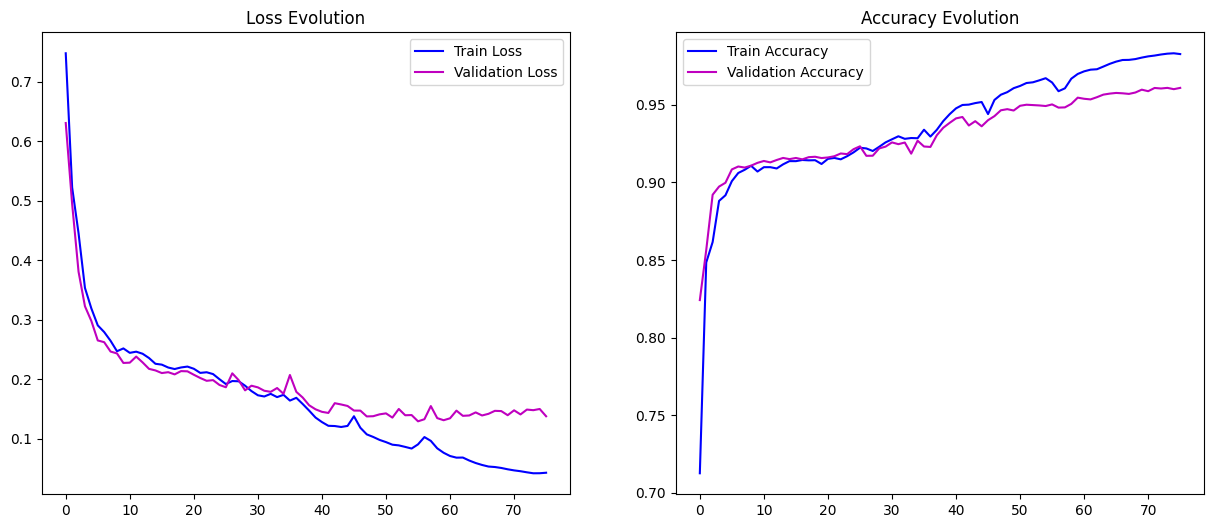

In [27]:
Loss_Acc_Evol(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


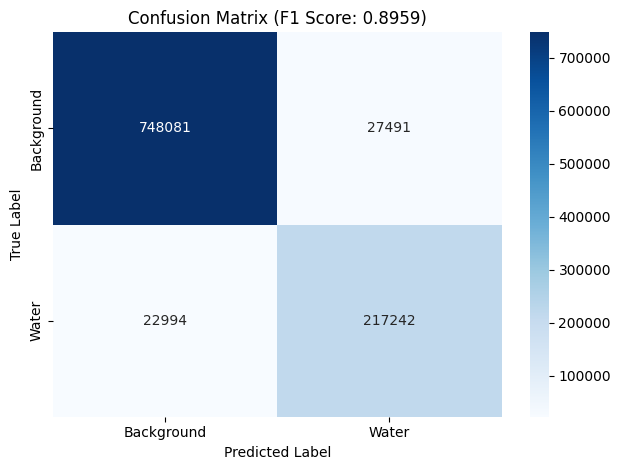

In [28]:
plot_conf_matrix(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


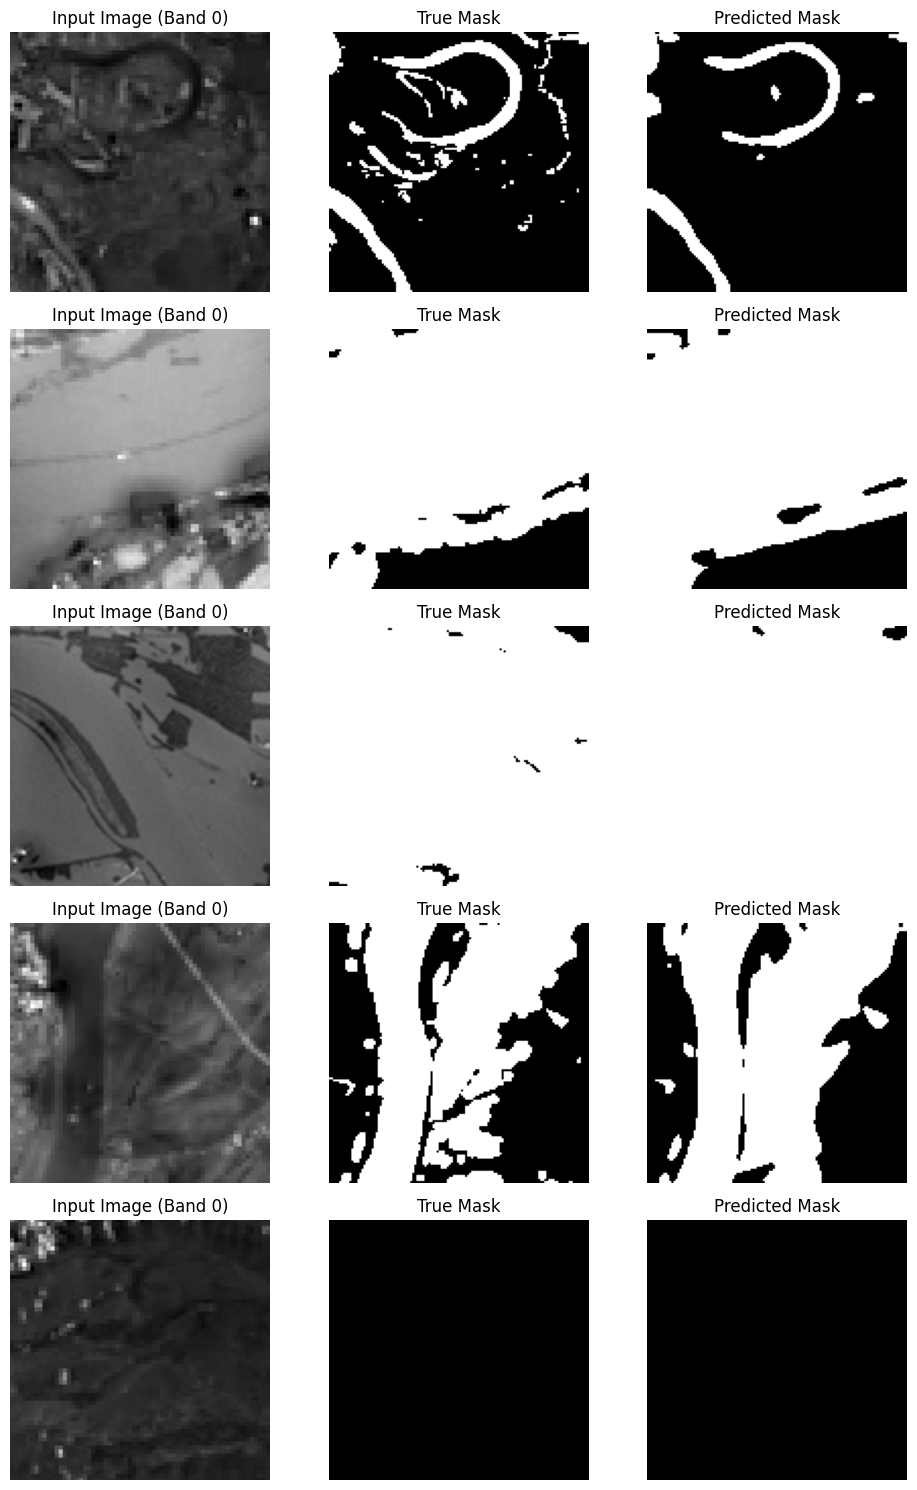

In [29]:
plot_pred_masks(model)

# Save Model

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ dropout_1[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │          0 │ conv2d_28[0][0] 

 Total params: 94,152,389 (359.16 MB)

 Trainable params: 31,384,129 (119.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,768,260 (239.44 MB)

In [32]:
model.save('UNet_water_segmentation_from_scratch.h5')